# Smart Queue Monitoring System - Transportation Scenario

## Overview
In this notebook, we request an **IEI Tank-870** edge node and run inference on the different hardware types (CPU, GPU, VPU, FPGA).

After the inference is completed, the output video and stats files are retrieved and stored.

## Step 0: Set Up

#### IMPORTANT: Set up paths so we can run Dev Cloud utilities
You *must* run this every time you enter a Workspace session.
(Tip: select the cell and use **Shift+Enter** to run the cell.)

In [1]:
%env PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support
import os
import sys
sys.path.insert(0, os.path.abspath('/opt/intel_devcloud_support'))
sys.path.insert(0, os.path.abspath('/opt/intel'))

env: PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support


## Step 1 : Inference on a Video

In the next few cells, we submit a job using the `qsub` command and retrieve the results for each job. Each of the cells below should submit a job to different edge compute nodes.

The output of the cell is the `JobID` of your job, usefull to track progress of a job with `liveQStat`.

There is a submission job for each of the following hardware types:
* **CPU**
* **GPU**
* **VPU**
* **FPGA**


After submission, they will go into a queue and run as soon as the requested compute resources become available. 

If the job successfully runs and completes, it outputs a video and a stats text file in the `results/manufacturing/<DEVICE>` directory.

## Step 1.1: Submit to an Edge Compute Node with an Intel® CPU
The script below submits a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a 
    href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core™ i5-6500TE processor</a>. The inference workload should run on the CPU.

In [5]:
# Function to submit job
model_path = '/data/models/intel/person-detection-retail-0013/FP16/person-detection-retail-0013'
video_path = '/data/resources/transportation.mp4'
queue_param = '/data/queue_param/transportation.npy'
max_people = 7

def submit_job(device,node_name):
    device_name = device
    if device_name.startswith('HETERO:FPGA'):
        device_name = 'FPGA'
    elif device_name.startswith('MYRIAD'):
        device_name = "VPU"
        
    
    output_path = '/output/results/transportation/' + str.lower(device_name)
    flag = '{} {} {} {} {} {}'.format(model_path, device, video_path, queue_param, output_path, max_people)
    
    job_name = "transportation_" + str.lower(device_name)
    
    job_ID = !qsub queue_job.sh -l nodes=1:{node_name} -d . -F "{flag}" -N job_name

    return job_ID

In [6]:
#Submit job to the queue
cpu_job_id = submit_job('CPU', 'tank-870:i5-6500te')

print(cpu_job_id[0])

a0VVXCwFXD7bIU0qJe9TcsnRizERHHrF


#### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job.

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [7]:
import liveQStat
liveQStat.liveQStat()

#### Get Results

Run the next cell to retrieve your job's results.

In [8]:
import get_results
get_results.getResults(cpu_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:a0VVXCwFXD7bIU0qJe9TcsnRizERHHrF) are ready.
Please wait.................................Success!
output.tgz was downloaded in the same folder as this notebook.


#### Unpack your output files and view stdout.log

In [9]:
!tar zxf output.tgz

In [10]:
!cat stdout.log

Loading the model
Model Loaded
Total model load time:  1.5972614288330078 ms
Adding queue params.
Starting inference
Total people on frame = 8
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 6
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people

#### View stderr.log
This can be used for debugging

In [11]:
!cat stderr.log

person_detect.py:53: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  self.model = IENetwork(self.model_structure, self.model_weights)


#### View Output Video
Run the cell below to view the output video. If inference was successfully run, you should see a video with bounding boxes drawn around each person detected.

In [12]:
import videoHtml

videoHtml.videoHTML('Transportation CPU', ['results/transportation/cpu/output_video.mp4'])

## Step 1.2: Submit to an Edge Compute Node with CPU and IGPU
The script below submits a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank* 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel® Core i5-6500TE</a>. The inference workload should run on the **Intel® HD Graphics 530** integrated GPU.

In [13]:
#Submit job to the queue
gpu_job_id = submit_job('GPU', 'tank-870:i5-6500te:intel-hd-530')

print(gpu_job_id[0])

24QnALpCy4cjcDg4nFIWbZAHdkclNS0m


### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job.

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [14]:
import liveQStat
liveQStat.liveQStat()

#### Get Results

Run the next cell to retrieve your job's results.

In [15]:
import get_results
get_results.getResults(gpu_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:24QnALpCy4cjcDg4nFIWbZAHdkclNS0m) are ready.
Please wait.................................................Success!
output.tgz was downloaded in the same folder as this notebook.


#### Unpack your output files and view stdout.log

In [16]:
!tar zxf output.tgz

In [17]:
!cat stdout.log

Loading the model
Model Loaded
Total model load time:  56.78744149208069 ms
Adding queue params.
Starting inference
Total people on frame = 8
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 6
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people 

#### View stderr.log
This can be used for debugging

In [18]:
!cat stderr.log

person_detect.py:53: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  self.model = IENetwork(self.model_structure, self.model_weights)


#### View Output Video
Run the cell below to view the output video. If inference was successfully run, you should see a video with bounding boxes drawn around each person detected.

In [19]:
import videoHtml

videoHtml.videoHTML('Transportation GPU', ['results/transportation/gpu/output_video.mp4'])

## Step 1.3: Submit to an Edge Compute Node with an Intel® Neural Compute Stick 2
The script below submitsa job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core i5-6500te CPU</a>. The inference workload should run on an <a 
    href="https://software.intel.com/en-us/neural-compute-stick">Intel Neural Compute Stick 2</a> installed in this  node.

In [20]:
#Submit job to the queue
vpu_job_id = submit_job('MYRIAD', 'tank-870:i5-6500te:intel-ncs2')

print(vpu_job_id[0])

iWJMfjmbnRZljYJhHZwdocOZJ7gweNMs


### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job.

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [21]:
import liveQStat
liveQStat.liveQStat()

#### Get Results

Run the next cell to retrieve your job's results.

In [22]:
import get_results
get_results.getResults(vpu_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:iWJMfjmbnRZljYJhHZwdocOZJ7gweNMs) are ready.
Please wait.....................................................Success!
output.tgz was downloaded in the same folder as this notebook.


#### Unpack your output files and view stdout.log

In [23]:
!tar zxf output.tgz

In [24]:
!cat stdout.log

Loading the model
Model Loaded
Total model load time:  3.1275382041931152 ms
Adding queue params.
Starting inference
Total people on frame = 8
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 6
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 7
Number of people in queue = {1: 2, 2: 0}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people on frame = 8
Number of people in queue = {1: 2, 2: 1}
Total people

#### View stderr.log
This can be used for debugging

In [25]:
!cat stderr.log

person_detect.py:53: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  self.model = IENetwork(self.model_structure, self.model_weights)


#### View Output Video
Run the cell below to view the output video. If inference was successfully run, you should see a video with bounding boxes drawn around each person detected.

In [26]:
import videoHtml

videoHtml.videoHTML('Transportation VPU', ['results/transportation/vpu/output_video.mp4'])

## Step 1.4: Submit to an Edge Compute Node with IEI Mustang-F100-A10
The script below submits a job to an <a 
    href="https://software.intel.com/en-us/iot/hardware/iei-tank-dev-kit-core">IEI 
    Tank 870-Q170</a> edge node with an <a href="https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz-">Intel Core™ i5-6500te CPU</a> . The inference workload will run on the <a href="https://www.ieiworld.com/mustang-f100/en/"> IEI Mustang-F100-A10 </a> FPGA card installed in this node.

In [27]:
#Submit job to the queue
fpga_job_id = submit_job('HETERO:FPGA,CPU', 'tank-870:i5-6500te:iei-mustang-f100-a10')

print(fpga_job_id[0])

MXps2R4Iv9NMvnMoyZnMdKeaS46gzaRF


### Check Job Status

To check on the job that was submitted, use `liveQStat` to check the status of the job.

Column `S` shows the state of your running jobs.

For example:
- If `JOB ID`is in Q state, it is in the queue waiting for available resources.
- If `JOB ID` is in R state, it is running.

In [28]:
import liveQStat
liveQStat.liveQStat()

#### Get Results

Run the next cell to retrieve your job's results.

In [29]:
import get_results
get_results.getResults(fpga_job_id[0], filename='output.tgz', blocking=True)

getResults() is blocking until results of the job (id:MXps2R4Iv9NMvnMoyZnMdKeaS46gzaRF) are ready.
Please wait..........................................................Success!
output.tgz was downloaded in the same folder as this notebook.


#### Unpack your output files and view stdout.log

In [30]:
!tar zxf output.tgz

In [31]:
!cat stdout.log

INTELFPGAOCLSDKROOT is not set
Using script's current directory (/opt/altera/aocl-pro-rte/aclrte-linux64)

aoc was not found, but aocl was found. Assuming only RTE is installed.

AOCL_BOARD_PACKAGE_ROOT is set to /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/BSP/a10_1150_sg2. Using that.
Adding /opt/altera/aocl-pro-rte/aclrte-linux64/bin to PATH
Adding /opt/altera/aocl-pro-rte/aclrte-linux64/linux64/lib to LD_LIBRARY_PATH
Adding /opt/altera/aocl-pro-rte/aclrte-linux64/host/linux64/lib to LD_LIBRARY_PATH
Adding /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/BSP/a10_1150_sg2/linux64/lib to LD_LIBRARY_PATH
aocl program: Running program from /opt/intel/openvino/bitstreams/a10_vision_design_sg2_bitstreams/BSP/a10_1150_sg2/linux64/libexec
Programming device: a10gx_2ddr : Intel Vision Accelerator Design with Intel Arria 10 FPGA (acla10_1150_sg20)
Program succeed. 
Loading the model
Model Loaded
Total model load time:  28.79678702354431 ms
Adding queue params

#### View stderr.log
This can be used for debugging

In [32]:
!cat stderr.log

person_detect.py:53: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  self.model = IENetwork(self.model_structure, self.model_weights)


#### View Output Video
Run the cell below to view the output video. If inference was successfully run, you should see a video with bounding boxes drawn around each person detected.

In [33]:
import videoHtml

videoHtml.videoHTML('Transportation FPGA', ['results/transportation/fpga/output_video.mp4'])

***Wait!***

Please wait for all the inference jobs and video rendering to complete before proceeding to the next step.

## Step 2: Assess Performance

Run the cells below to compare the performance across all 4 devices. The following timings for the model are being comapred across all 4 devices:

- Model Loading Time
- Average Inference Time
- FPS

In [34]:
import matplotlib.pyplot as plt

device_list=['cpu', 'gpu', 'fpga', 'vpu']
inference_time=[]
fps=[]
model_load_time=[]

for device in device_list:
    with open('results/transportation/'+device+'/stats.txt', 'r') as f:
        inference_time.append(float(f.readline().split("\n")[0].split(" ")[4]))
        fps.append(float(f.readline().split("\n")[0].split(" ")[3]))
        model_load_time.append(float(f.readline().split("\n")[0].split(" ")[4]))

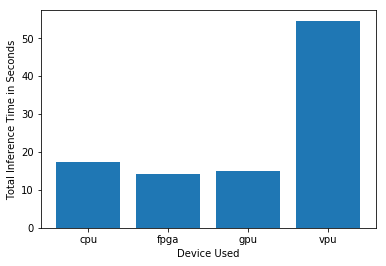

In [35]:
plt.bar(device_list, inference_time)
plt.xlabel("Device Used")
plt.ylabel("Total Inference Time in Seconds")
plt.show()

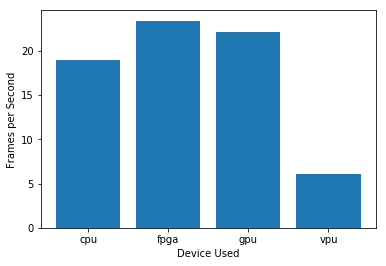

In [36]:
plt.bar(device_list, fps)
plt.xlabel("Device Used")
plt.ylabel("Frames per Second")
plt.show()

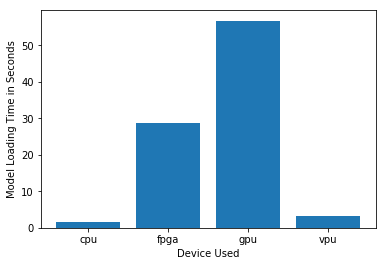

In [37]:
plt.bar(device_list, model_load_time)
plt.xlabel("Device Used")
plt.ylabel("Model Loading Time in Seconds")
plt.show()